In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

In [32]:
data = pd.read_csv('/Users/andreavento/Downloads/Default_Fin.csv.xls')
data

,Index,Employed,Bank Balance,Annual Salary,Defaulted?
0,1,1,8754.36,532339.56,0
1,2,0,9806.16,145273.56,0
2,3,1,12882.60,381205.68,0
3,4,1,6351.00,428453.88,0
4,5,1,9427.92,461562.00,0
...,...,...,...,...,...
9995,9996,1,8538.72,635908.56,0
9996,9997,1,9095.52,235928.64,0
9997,9998,1,10144.92,703633.92,0
9998,9999,1,18828.12,440029.32,0


In [33]:
data = data.drop(['Index'], axis = 1)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Employed       10000 non-null  int64  
 1   Bank Balance   10000 non-null  float64
 2   Annual Salary  10000 non-null  float64
 3   Defaulted?     10000 non-null  int64  
dtypes: float64(2), int64(2)
memory usage: 312.6 KB


Let's introduce a new feature, Saving Ratio, to understand the saving and spending behaviours of the subjects. 

In [34]:
data['Saving Ratio'] = (data['Bank Balance'] / data['Annual Salary']) *100

array([[<Axes: title={'center': 'Employed'}>,
        <Axes: title={'center': 'Bank Balance'}>],
       [<Axes: title={'center': 'Annual Salary'}>,
        <Axes: title={'center': 'Defaulted?'}>],
       [<Axes: title={'center': 'Saving Ratio'}>, <Axes: >]], dtype=object)

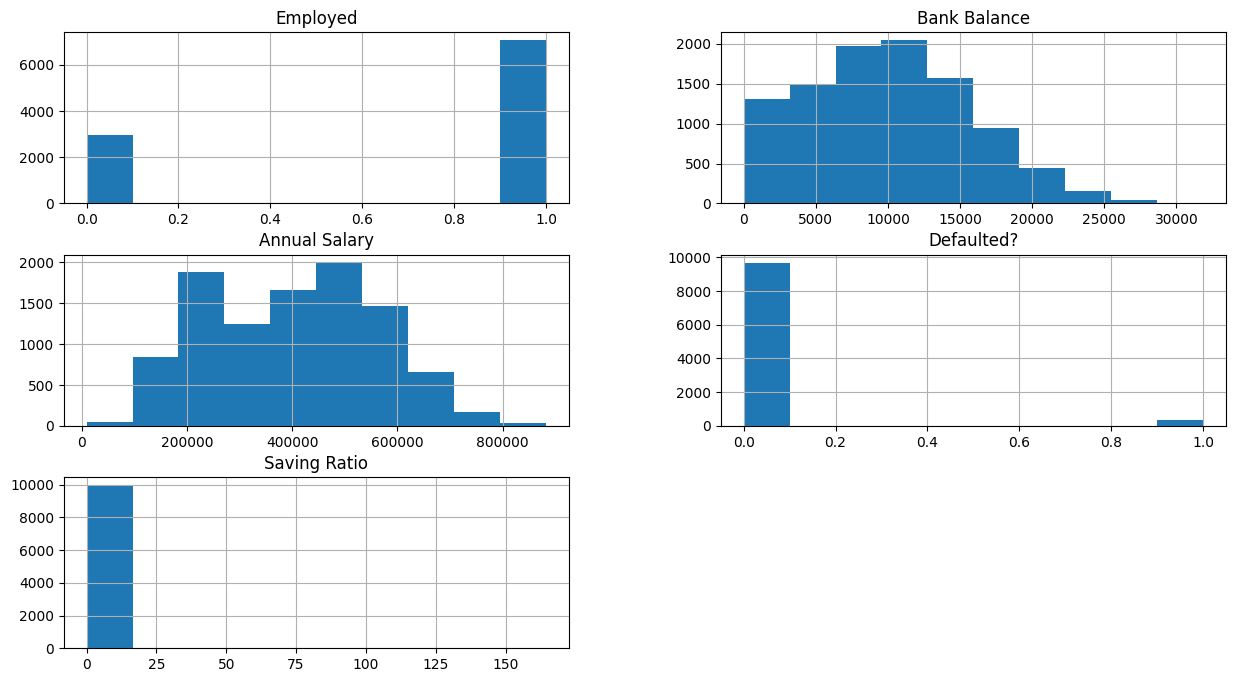

In [35]:
data.hist(figsize=(15,8))

<Axes: >

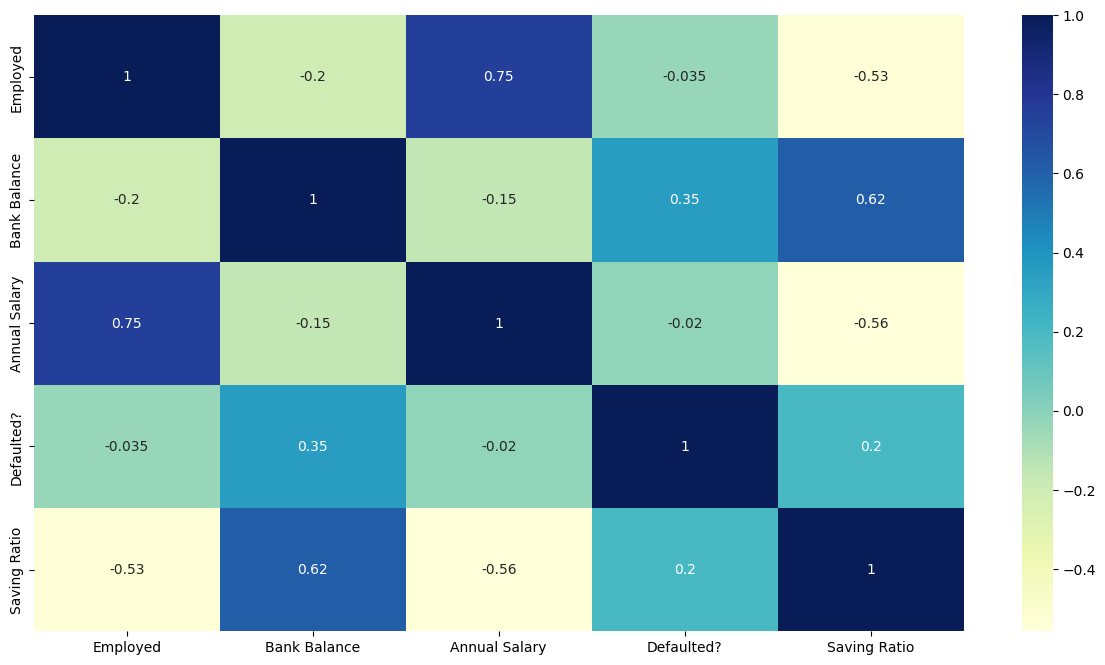

In [36]:
plt.figure(figsize=(15,8))
sns.heatmap(data.corr(), annot = True, cmap='YlGnBu')

No values missing, no need to drop NA values

In [37]:
fig = px.pie(data, values = data['Defaulted?'].value_counts(), names = ['Did not default','Defaulted'], title = 'Distribution of Clients Who Have Defaulted')
fig.update_traces(rotation=90, pull = [0.2,0.06,0.06,0.06,0.06], textinfo = "percent+label")
fig.show()

Our target variable is highly imbalanced, we'll need to take this into consideration. 

Text(0.5, 0.98, '')

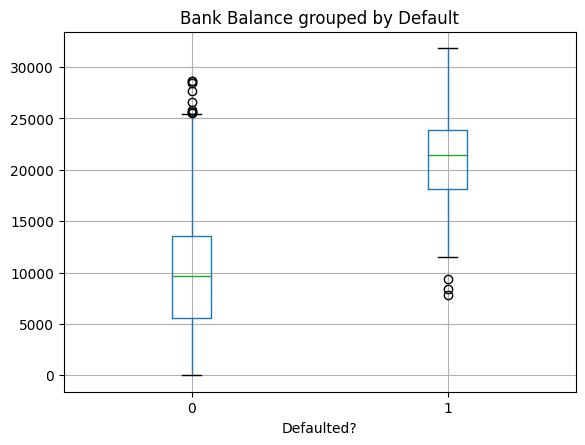

In [38]:
data.boxplot(column='Bank Balance', by='Defaulted?')
plt.title('Bank Balance grouped by Default')
plt.suptitle('')

Those with higher bank balance tend to be more prone to defaulting, probably because financial institutions approve more loan requests coming from them.

Text(0.5, 0.98, '')

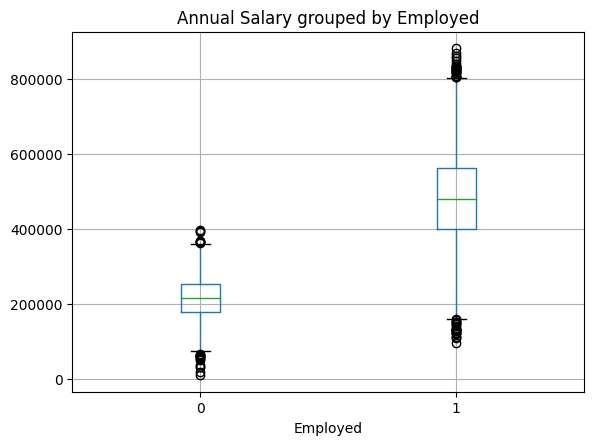

In [39]:
data.boxplot(column='Annual Salary', by='Employed')
plt.title('Annual Salary grouped by Employed')
plt.suptitle('')

As expected, employed people have higher median annual salary. 

Text(0.5, 0.98, '')

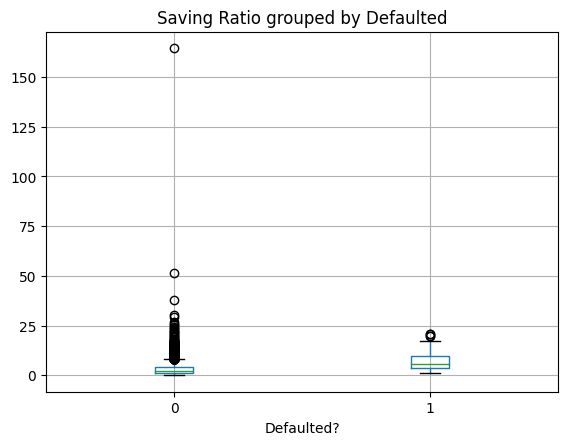

In [40]:
data.boxplot(column='Saving Ratio', by= 'Defaulted?')
plt.title('Saving Ratio grouped by Defaulted')
plt.suptitle('')


As we can see, Saving Ratio is clearly right skewed. Scaling could be useful. 
Let's divide our dataset in target and non-target variables

In [41]:
from sklearn.model_selection import train_test_split
X = data.drop(['Defaulted?'], axis=1)
y = data['Defaulted?']
y

0       0
1       0
2       0
3       0
4       0
       ..
9995    0
9996    0
9997    0
9998    0
9999    0
Name: Defaulted?, Length: 10000, dtype: int64

Let's split our dataset into train and test, so that only 80% of the observations will be used to train the model. 

In [42]:
X_train , X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)
train_data = X_train.join(y_train)
train_data

,Employed,Bank Balance,Annual Salary,Saving Ratio,Defaulted?
9285,0,13540.32,188029.20,7.201179,0
8974,0,16870.56,324855.84,5.193245,0
2276,1,10886.04,331578.84,3.283092,0
7860,0,20107.92,249277.56,8.066478,0
9461,0,12495.72,144945.36,8.620987,0
...,...,...,...,...,...
8672,1,5046.00,699170.52,0.721712,0
595,0,13328.16,231930.96,5.746607,0
9657,1,2620.56,432537.84,0.605857,0
5924,0,4503.72,232105.92,1.940373,0


Let's import our classifiers and the function to evaluate them

In [43]:
from sklearn.linear_model import LogisticRegression,RidgeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,PowerTransformer
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, recall_score, precision_score,recall_score, f1_score,confusion_matrix

def evaluate_classifier(y_test, y_pred):
    accuracy = accuracy_score(y_test,y_pred)
    print(f'Accuracy: {accuracy*100:.2f}%')
    recall = recall_score(y_test,y_pred)
    print(f'Recall: {recall*100:.2f}%')
    precision = precision_score(y_test,y_pred)
    print(f'Precision: {precision*100:.2f}%')
    f1 = f1_score(y_test,y_pred)
    print(f'F1 Score: {f1*100:.2f}%')
    cm = confusion_matrix(y_test, y_pred)
    df_cm = pd.DataFrame(cm, index=['True (Did not default)', 'True (Defaulted)'], columns=['Predicted (Did not default)', 'Predicted (Defaulted)'])
    fig, ax = plt.subplots(figsize=(10,7))
    ax = sns.heatmap(df_cm, annot=True,fmt='d', annot_kws={"size": 15})

    return accuracy, recall, precision, f1


In [44]:
y_train.value_counts()

0    7732
1     268
Name: Defaulted?, dtype: int64

Since our target variable is imbalanced, we use the SMOTE method

In [45]:
smote = SMOTE()
X_train1 , y_train1 = smote.fit_resample(X_train, y_train)
y_train1.value_counts()

0    7732
1    7732
Name: Defaulted?, dtype: int64

Let's run and evaluate Logistic regression on the train set. 

Accuracy: 66.55%
Recall: 90.77%
Precision: 8.17%
F1 Score: 14.99%


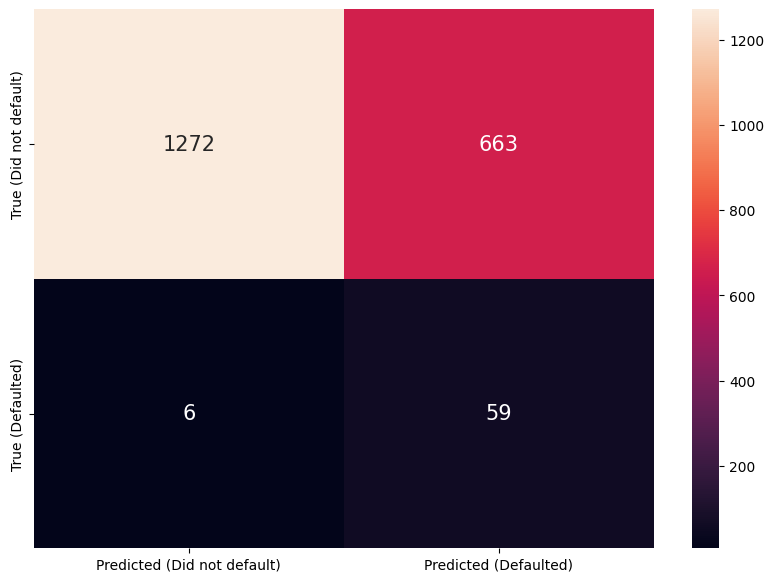

In [46]:
logreg = LogisticRegression()
logreg.fit(X_train1, y_train1)
y_pred = logreg.predict(X_test)
Logistic_regr_stats = evaluate_classifier(y_test, y_pred)

Let's run and evaluate Decision Tree on the train set. 

Accuracy: 90.35%
Recall: 63.08%
Precision: 19.52%
F1 Score: 29.82%


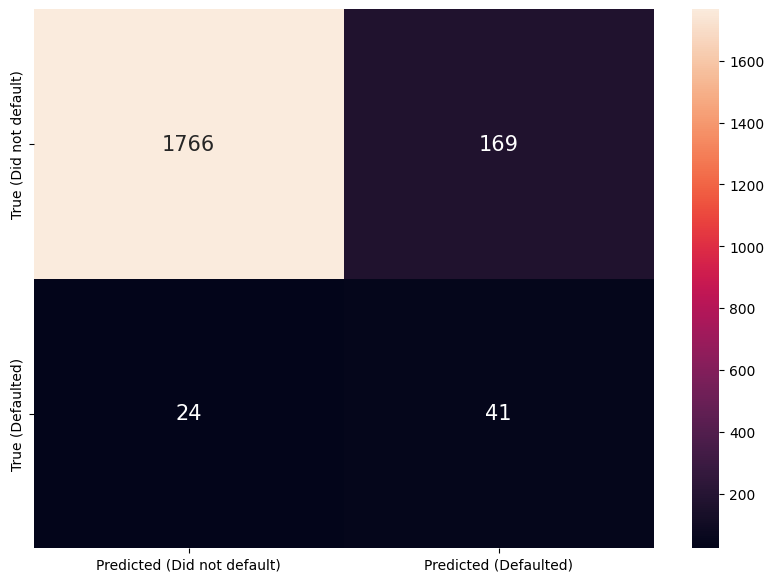

In [47]:
dtree = DecisionTreeClassifier()
dtree.fit(X_train1, y_train1)
y_pred = dtree.predict(X_test)
dtree_stats = evaluate_classifier(y_test, y_pred)

Let's run and evaluate Random Forest on the train set. 

Accuracy: 89.95%
Recall: 75.38%
Precision: 20.94%
F1 Score: 32.78%


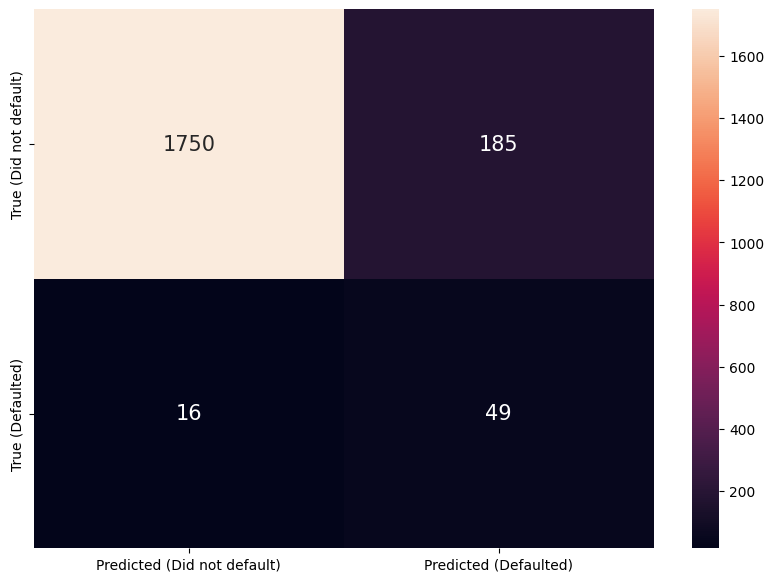

In [48]:
randomforest = RandomForestClassifier(n_estimators=500)
randomforest.fit(X_train1, y_train1)
y_pred = randomforest.predict(X_test)
randomforest_stats = evaluate_classifier(y_test, y_pred)

Accuracy: 84.25%
Recall: 86.15%
Precision: 15.47%
F1 Score: 26.23%


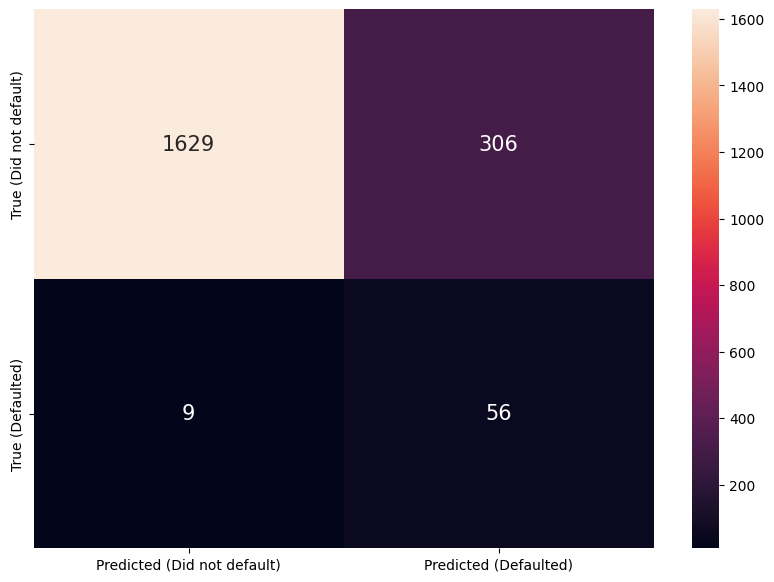

In [49]:
rc = RidgeClassifier()
rc.fit(X_train1, y_train1)
y_pred = rc.predict(X_test)
rc_stats = evaluate_classifier(y_test, y_pred)

In [50]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Let's apply the smote method to our scaled data
X_train2, y_train2 = smote.fit_resample(X_train_scaled, y_train)

Logistic regression scaled

Accuracy: 87.15%
Recall: 86.15%
Precision: 18.42%
F1 Score: 30.35%


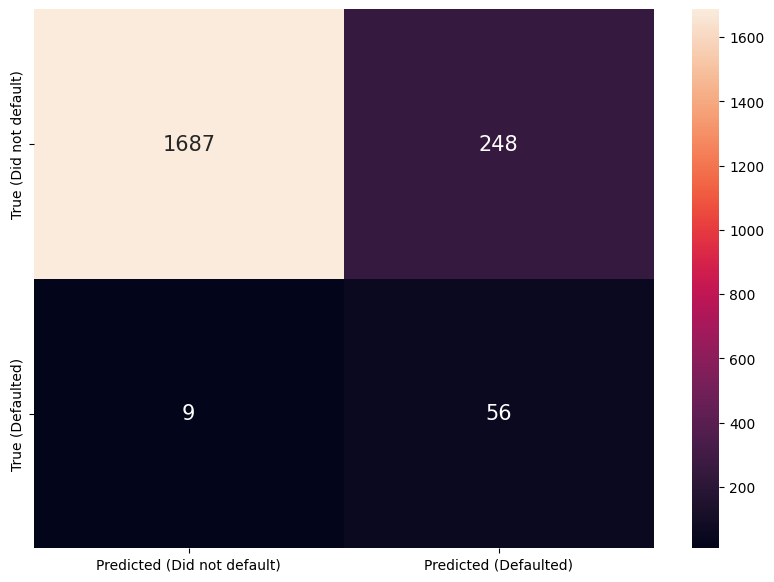

In [51]:
logreg = LogisticRegression()
logreg.fit(X_train2, y_train2)
y_pred = logreg.predict(X_test_scaled)
Logistic_regr_stats_scaled = evaluate_classifier(y_test, y_pred)

Decision Tree scaled

Accuracy: 89.75%
Recall: 60.00%
Precision: 17.89%
F1 Score: 27.56%


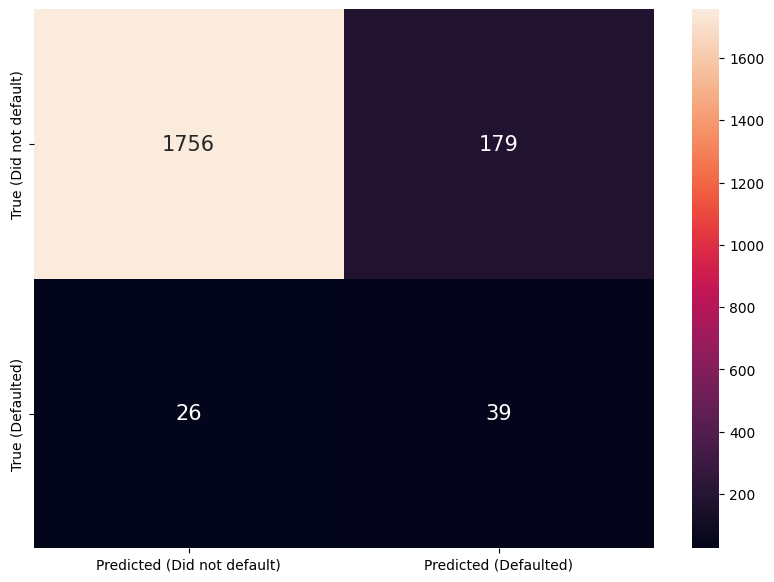

In [52]:
dtree = DecisionTreeClassifier()
dtree.fit(X_train2, y_train2)
y_pred = dtree.predict(X_test_scaled)
dtree_stats_scaled = evaluate_classifier(y_test, y_pred)

Random Forest Scaled

Accuracy: 90.05%
Recall: 66.15%
Precision: 19.55%
F1 Score: 30.18%


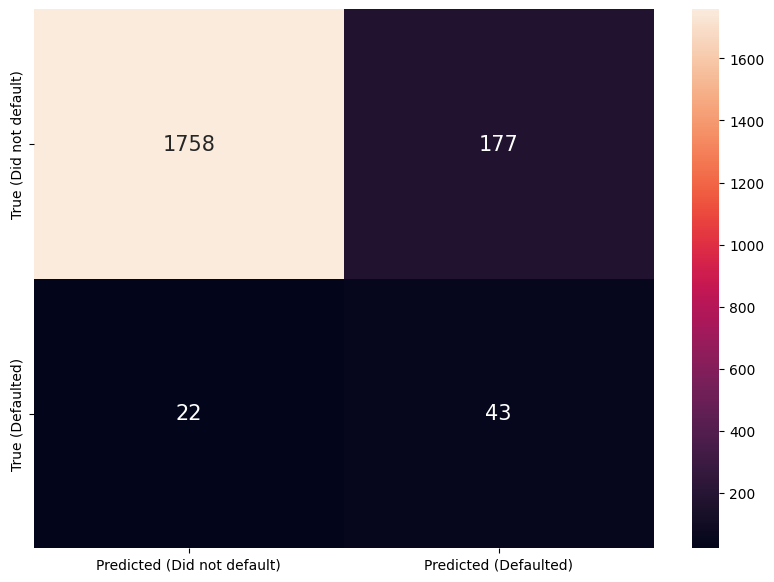

In [53]:
randomforest = RandomForestClassifier(n_estimators=500)
randomforest.fit(X_train2, y_train2)
y_pred = randomforest.predict(X_test_scaled)
randomforest_stats_scaled = evaluate_classifier(y_test, y_pred)

Evaluate Ridgeclassifier scaled

Accuracy: 84.35%
Recall: 87.69%
Precision: 15.75%
F1 Score: 26.70%


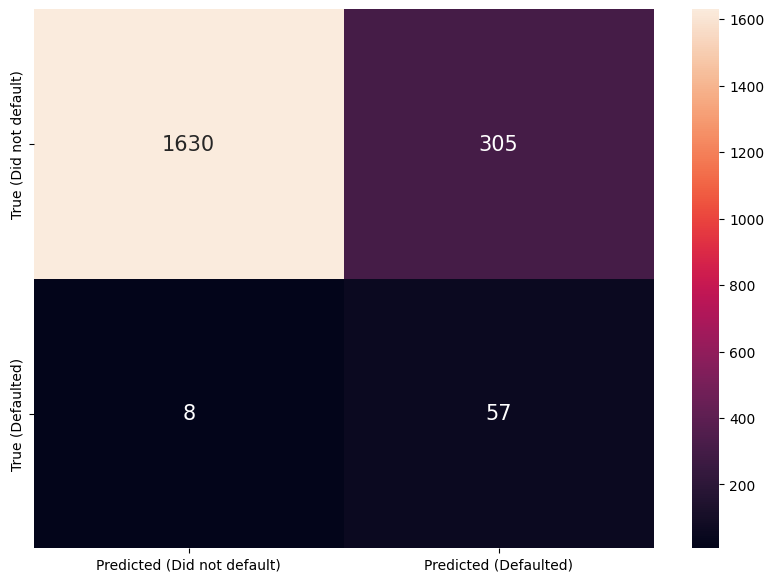

In [54]:
rc = RidgeClassifier()
rc.fit(X_train2, y_train2)
y_pred = rc.predict(X_test_scaled)
rc_stats_scaled = evaluate_classifier(y_test, y_pred)

In [55]:
model_names = ['Logistic Regression', 'Decision Tree', 'Random Forest', 'Ridge Classifier']
model_stats = [Logistic_regr_stats, dtree_stats, randomforest_stats, rc_stats]
def get_stats(model):
    l = []
    for i in range(3):
        l.append(model[i])
    return l
stats = [get_stats(model) for model in model_stats]

model_performance_df1 = pd.DataFrame(model_stats, columns=['Accuracy', 'Recall', 'Precision', 'F1 Score'])
model_performance_df1['Test'] = [model for model in model_names]

model_performance_df1 = model_performance_df1[['Test', 'Accuracy', 'Recall', 'Precision', 'F1 Score']]


model_performance_df1


,Test,Accuracy,Recall,Precision,F1 Score
0,Logistic Regression,0.6655,0.907692,0.081717,0.149936
1,Decision Tree,0.9035,0.630769,0.195238,0.298182
2,Random Forest,0.8995,0.753846,0.209402,0.327759
3,Ridge Classifier,0.8425,0.861538,0.154696,0.262295


(array([0, 1, 2, 3]),
 [Text(0, 0, 'Accuracy'),
  Text(1, 0, 'Recall'),
  Text(2, 0, 'Precision'),
  Text(3, 0, 'F1 Score')])

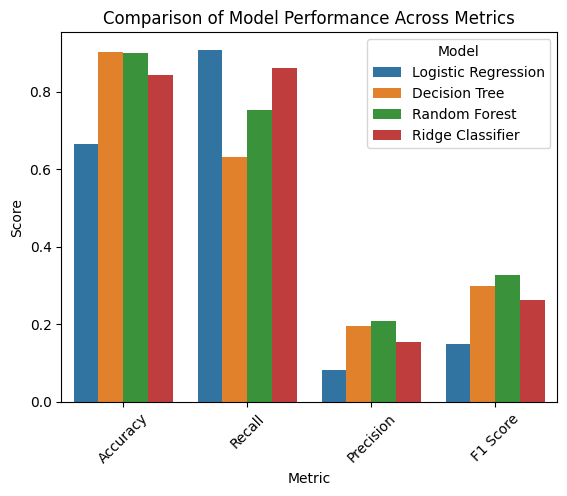

In [56]:
long_df = model_performance_df1.melt(id_vars='Test', var_name='Metric', value_name='Value')
sns.barplot(data=long_df, x='Metric', y='Value', hue='Test')
plt.title('Comparison of Model Performance Across Metrics')
plt.xlabel('Metric')
plt.ylabel('Score')
plt.legend(title='Model')
plt.xticks(rotation=45)

In [57]:
model_names = ['Logistic Regression', 'Decision Tree', 'Random Forest', 'Ridge Classifier']
model_stats = [Logistic_regr_stats_scaled, dtree_stats_scaled, randomforest_stats_scaled, rc_stats_scaled]
def get_stats(model):
    l = []
    for i in range(3):
        l.append(model[i])
    return l
stats = [get_stats(model) for model in model_stats]

model_performance_df2 = pd.DataFrame(model_stats, columns=['Accuracy', 'Recall', 'Precision', 'F1 Score'])
model_performance_df2['Test'] = [model for model in model_names]

# Reorder the DataFrame columns to have 'Model' first
model_performance_df2 = model_performance_df2[['Test', 'Accuracy', 'Recall', 'Precision', 'F1 Score']]

# Display the DataFrame
model_performance_df2

,Test,Accuracy,Recall,Precision,F1 Score
0,Logistic Regression,0.8715,0.861538,0.184211,0.303523
1,Decision Tree,0.8975,0.600000,0.178899,0.275618
2,Random Forest,0.9005,0.661538,0.195455,0.301754
3,Ridge Classifier,0.8435,0.876923,0.157459,0.266979


(array([0, 1, 2, 3]),
 [Text(0, 0, 'Accuracy'),
  Text(1, 0, 'Recall'),
  Text(2, 0, 'Precision'),
  Text(3, 0, 'F1 Score')])

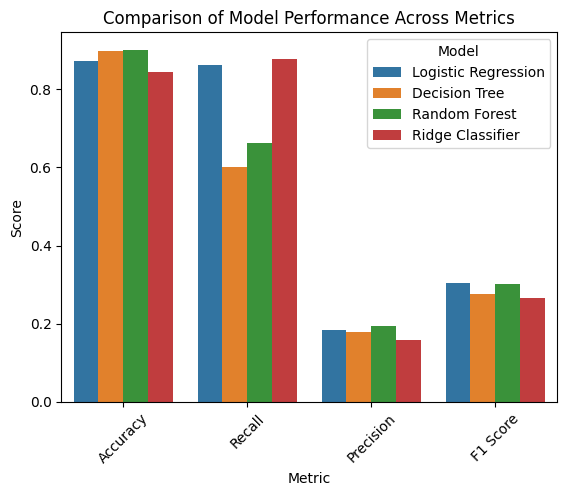

In [58]:
long_df = model_performance_df2.melt(id_vars='Test', var_name='Metric', value_name='Value')
sns.barplot(data=long_df, x='Metric', y='Value', hue='Test')
plt.title('Comparison of Model Performance Across Metrics')
plt.xlabel('Metric')
plt.ylabel('Score')
plt.legend(title='Model')
plt.xticks(rotation=45)

In [59]:
model_performance_df1 = model_performance_df1.set_index('Test')
model_performance_df2 = model_performance_df2.set_index('Test')

# Now that they're aligned, you can subtract them
difference_df = -(model_performance_df1 - model_performance_df2)
difference_df

,Accuracy,Recall,Precision,F1 Score
Test,,,,
Logistic Regression,0.206,-0.046154,0.102493,0.153587
Decision Tree,-0.006,-0.030769,-0.016339,-0.022563
Random Forest,0.001,-0.092308,-0.013947,-0.026005
Ridge Classifier,0.001,0.015385,0.002762,0.004684


(array([0, 1, 2, 3]),
 [Text(0, 0, 'Logistic Regression'),
  Text(1, 0, 'Decision Tree'),
  Text(2, 0, 'Random Forest'),
  Text(3, 0, 'Ridge Classifier')])

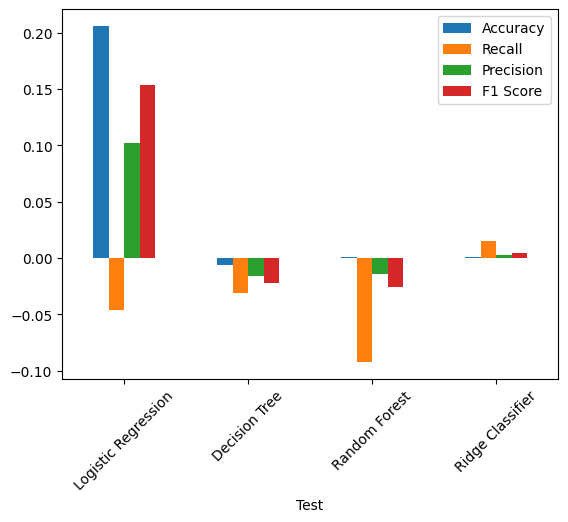

In [60]:
difference_df.plot.bar()
plt.xticks(rotation=45)

We can see how logistic regression model benefits from the scaling operation (outliers effect reduced) wwhile the other models are not much affected (the effect is less than 3% on average).

Since our goal is to minimize the risk for the bank, misclassifying a probable defulter could cause serious consequences, whereas having false positives (a non-defaulter classified as a risky client) brings smaller problems. Therefore, the main matrix we should maximize is recall. Moreover, accuracy is not very informative since out dataset is highly imbalanced and could easly be cheated on by classifying every case as 0 (non-defaulter), getting a 99% accuracy. 